# 2D Image Segmentation of MRI scans

Steps:
1. Get dataset
1. Preprocess 2D images
    1. do a
    1. do b
1. Split dataset into train/val(/test) set
1. Setup a model
1. Set training and model parameters
1. Train model
1. Validate result


## Get dataset


In [1]:
!pip3 install natsort

In [3]:
import os
import random
import re
import numpy as np
from PIL import Image
from random import sample
from pathlib import Path

DATASET = "/Utrecht"
DATA_PATH = 'data_2d' + DATASET
SCAN_TYPE = 'T1'
FRAME_PATH = DATA_PATH
MASK_PATH = DATA_PATH

# Data path
# data_2d/<dataset>/<scan_id>/
# data_2d/<dataset>/<scan_id>/wmh_<slice_id>.tif
# data_2d/<dataset>/<scan_id>/orig/3DT1_<slice_id>.tif
# data_2d/<dataset>/<scan_id>/orig/T1_<slice_id>.tif
# data_2d/<dataset>/<scan_id>/orig/FLAIR_<slice_id>.tif
# data_2d/<dataset>/<scan_id>/pre/3DT1_<slice_id>.tif
# data_2d/<dataset>/<scan_id>/pre/T1_<slice_id>.tif
# data_2d/<dataset>/<scan_id>/pre/FLAIR_<slice_id>.tif


# Create folders to hold images and masks

folders = ['train_frames', 'train_masks', 'val_frames', 'val_masks', 'test_frames', 'test_masks']


# for folder in folders:
#       os.makedirs(DATA_PATH + folder)


# Get all frames and masks, sort them, shuffle them to generate data sets.

''' Recursively find all Images from a filepath matching the description 

    @return tuple (frames, masks) with list of all frames an accompanying mask
'''
def getAllImages(dataPath, scanType = "T1", preprocessed=True):
    if preprocessed:
        imageType = 'pre'
    else:
        imageType = 'orig'
    
    frameExpression = '**/{}/{}*.tiff'.format(imageType, scanType)
    maskExpression = '**/wmh_*.tiff' 
    a =  Path(DATA_PATH).glob(frameExpression)
    b =  Path(DATA_PATH).glob(maskExpression)

    while True:
        yield next(a), next(b)
    
    
    
# all_frames = os.listdir(FRAME_PATH)
# for frame in Path(DATA_PATH).glob('**/pre/{}*.tif'.format(SCAN_TYPE)):
#     print(frame)

# all_masks = os.listdir(MASK_PATH)

In [4]:
a = getAllImages(DATA_PATH)
all_frames = [str(x) for (x,_) in getAllImages(DATA_PATH) if 'checkpoint' not in str(x) ]

all_masks = [str(x) for (_,x) in getAllImages(DATA_PATH) if 'checkpoint' not in str(x)] 

from natsort import natsorted, ns
all_frames = natsorted(all_frames, alg=ns.IGNORECASE)
all_masks = natsorted(all_masks, alg=ns.IGNORECASE)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: generator 'getAllImages' raised StopIteration
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: generator 'getAllImages' raised StopIteration
  after removing the cwd from sys.path.


In [5]:
print(len(all_frames))
print(len(all_masks))
arr = [random.randint(0,len(all_frames)) for _ in range(10)]
for i in arr:
    print('Random entry in data:')
    print(f'frame {all_frames[i]}, mask  {all_masks[i]}')


   

600
600
Random entry in data:
frame data_2d/Utrecht/37/pre/T1_13.tiff, mask  data_2d/Utrecht/37/wmh_13.tiff
Random entry in data:
frame data_2d/Utrecht/2/pre/T1_23.tiff, mask  data_2d/Utrecht/2/wmh_23.tiff
Random entry in data:
frame data_2d/Utrecht/17/pre/T1_31.tiff, mask  data_2d/Utrecht/17/wmh_31.tiff
Random entry in data:
frame data_2d/Utrecht/35/pre/T1_27.tiff, mask  data_2d/Utrecht/35/wmh_27.tiff
Random entry in data:
frame data_2d/Utrecht/6/pre/T1_32.tiff, mask  data_2d/Utrecht/6/wmh_32.tiff
Random entry in data:
frame data_2d/Utrecht/31/pre/T1_14.tiff, mask  data_2d/Utrecht/31/wmh_14.tiff
Random entry in data:
frame data_2d/Utrecht/2/pre/T1_24.tiff, mask  data_2d/Utrecht/2/wmh_24.tiff
Random entry in data:
frame data_2d/Utrecht/39/pre/T1_13.tiff, mask  data_2d/Utrecht/39/wmh_13.tiff
Random entry in data:
frame data_2d/Utrecht/8/pre/T1_21.tiff, mask  data_2d/Utrecht/8/wmh_21.tiff
Random entry in data:
frame data_2d/Utrecht/35/pre/T1_9.tiff, mask  data_2d/Utrecht/35/wmh_9.tiff


In [6]:
# all_frames.sort(key=lambda var:[int(x) if x.isdigit() else x 
#                                 for x in re.findall(r'[^0-9]|[0-9]+', var)])
# all_masks.sort(key=lambda var:[int(x) if x.isdigit() else x 
#                                for x in re.findall(r'[^0-9]|[0-9]+', var)])
# for i in range(10):
#     print(all_frames[i])
#     print(all_masks[i])
#     print()

# Get all indices     
idxs = [x for x in range(len(all_frames))]


## Split dataset into train, val and testset

In [7]:
random.seed(230)
random.shuffle(idxs)

# Generate train, val, and test sets for frames

train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1


train_split = int(0.7*len(all_frames))
val_split = int(0.9 * len(all_frames))

train_idxs = idxs[:train_split]
val_idxs = idxs[train_split:val_split]
test_idxs = idxs[val_split:]

In [8]:
# Get corresponding frames
train_frames = [all_frames[idx] for idx in train_idxs]
val_frames = [all_frames[idx] for idx in val_idxs]
test_frames = [all_frames[idx] for idx in test_idxs]

# Get corresponding masks
train_masks = [all_masks[idx] for idx in train_idxs]
val_masks = [all_masks[idx] for idx in val_idxs]
test_masks = [all_masks[idx] for idx in test_idxs]


In [9]:
x= 100
print(idxs[x])
print(all_frames[idxs[x]])
print(train_frames[x])
print(all_masks[idxs[x]])
print(train_masks[x])

256
data_2d/Utrecht/21/pre/T1_25.tiff
data_2d/Utrecht/21/pre/T1_25.tiff
data_2d/Utrecht/21/wmh_25.tiff
data_2d/Utrecht/21/wmh_25.tiff


In [10]:
import cv2
import matplotlib.pyplot as plt
def load_images_from_path_array(path_array):
    # Load all images (in memory for now)
    imgs = []
    for path in path_array:
        imgs.append(cv2.imread(path))
    return np.array(imgs)

train_x = load_images_from_path_array(train_frames).astype("float") / 255.0
train_y = load_images_from_path_array(train_masks).astype("float") / 255.0

val_x = load_images_from_path_array(val_frames).astype("float") / 255.0
val_y = load_images_from_path_array(val_masks).astype("float") / 255.0

test_x = load_images_from_path_array(test_frames).astype("float") / 255.0
test_y = load_images_from_path_array(test_masks).astype("float") / 255.0

In [11]:
print(train_x.shape)
print(train_x[0,:,:,0].reshape(240,240,1).shape)
train_x = train_x[:,:,:,0].reshape(420,240,240,1)
train_y = train_y[:,:,:,0].reshape(420,240,240,1)
print(train_x.shape)

(420, 240, 240, 3)
(240, 240, 1)
(420, 240, 240, 1)


In [12]:
print(val_x.shape)

(120, 240, 240, 3)


In [13]:
val_x = val_x[:,:,:,0].reshape(120,240,240,1)
val_y = val_y[:,:,:,0].reshape(120,240,240,1)

## Data is here. 

- [train/val/test]_[frames|masks]

Let's go


In [14]:
from model_unet import *
model = unet(input_size=(240,240,1))#train_x[0].shape);

Using TensorFlow backend.
W0802 16:41:43.921787 140001155729216 module_wrapper.py:136] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0802 16:41:43.948755 140001155729216 module_wrapper.py:136] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0802 16:41:44.015809 140001155729216 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0802 16:41:44.112287 140001155729216 module_wrapper.py:136] From /usr/local/lib/python3.6/dist-packages/te

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 240, 240, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 120, 120, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [15]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7573013314694327407
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17075383653120507255
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14587234614969576351
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5780471808
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16550232155144738226
physical_device_desc: "device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [16]:
model_checkpoint = ModelCheckpoint('unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
# model.loss = jaccard_distance_loss
model.fit(
    train_x,
    train_y,
    batch_size=4,
    epochs=1, 
    validation_data=(val_x,val_y),
    callbacks=[model_checkpoint],
    verbose=1
)

Train on 420 samples, validate on 120 samples
Epoch 1/1


W0802 16:41:59.469067 140001155729216 module_wrapper.py:136] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/util/module_wrapper.py:163: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.



UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_1/convolution}}]]
	 [[metrics/acc/Mean_1/_413]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv2d_1/convolution}}]]
0 successful operations.
0 derived errors ignored.

In [33]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 240, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 240, 240, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 120, 120, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [ ]:
predictions = model.predict(test_x[:,:,:,1].reshape(test_x.shape[0],240,240,1), batch_size = 16)

In [97]:
def figureplot():
    l = sample(range(0,240), 5)
    for i in range(0,5):
        plt.subplot(3,5, i+1)
        plt.imshow(train_x[l[i]][:,:,0])
        plt.title(l[i])
        plt.subplot(3,5, i+6)
        plt.imshow(train_y[l[i]][:,:,0])
        plt.subplot(3,5, i+11)
        plt.imshow(model.predict(train_x[l[i]])[:,:,0] )
        
    
    plt.show()

ValueError: Error when checking input: expected input_1 to have 4 dimensions, but got array with shape (240, 240, 3)

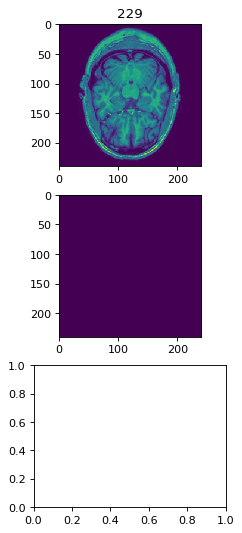

In [98]:
plt.figure(figsize=(18, 8), dpi= 80, facecolor='w', edgecolor='k')
figureplot()
    

In [111]:
a = []
a.append(train_x[3,:,:,1]);


In [116]:
train_x.shape

(420, 240, 240, 3)